[Word2Vec](#Word2Vec)

1. [Introduction](#Introduction)   
2. [References](#References)   
3. [The Idea Behind the Approach - Using Context Clues](#The-Idea-Behind-the-Approach---Using-Context-Clues)     
4. [Searching for Context Clues: Skip-Grams](#Searching-for-Context-Clues:-Skip-Grams)   
5. [The Neural Network](#The-Neural-Network)    
6. [Training Word2Vec is Costly](#Training-Word2Vec-is-Costly)   


# Word2Vec

## Introduction
In this section we'll be diving into how neural networks can be used to represent NLP data in what are known as embeddings. They are so called because we are taking higher dimensional data and finding clever ways to embed it into a smaller dimensional space.

By clever I mean that we'll be finding ways to embed that preserve some inherent nature of the data, for instance in a way that makes sense given a word's meaning in a piece of text. For example, a good word embedding should probably group the words "apple" and "pears" together (depending on the data set of course).


The first feed forward neural network based word embedding we'll touch on is Word2Vec. Word2Vec was an approach developed by Mikolov et. al. across two papers in 2013 (https://arxiv.org/abs/1301.3781 and https://arxiv.org/abs/1310.4546).

The key idea behind this approach is to look at the words that occur next to the word you're interested in across your corpus, an idea known as looking at the context surround the target word.

In this notebook we'll learn how to implement Word2Vec using an algorithm known as skip-gram with negative sampling (SGNS).

## References

Notably, Mikolov et. al.'s papers are a bit hard to decipher, so we'll actually be working off of a collection of other sources that are much more reader-friendly (i.e. I can understand them).

This notebook will build heavily off of the following sources:

* https://web.stanford.edu/~jurafsky/slp3/6.pdf
* https://www.tensorflow.org/tutorials/text/word2vec
* https://arxiv.org/abs/1411.2738
* https://www.youtube.com/watch?v=D-ekE-Wlcds

Let's go!

In [1]:
## We'll import these, but I don't know how much 
## we'll use them

## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from seaborn import set_style

## This sets the plot style
## to have a grid on a white background
set_style("whitegrid")

## The Idea Behind the Approach - Using Context Clues
Before diving into the nitty-gritty lets dive into the idea behind the approach.



 You shall know a word by the company it keeps 

J.R. Firth


At the heart of Word2Vec is the desire to learn the "meaning" of a word using context clues. Let's look at a simple example. Imagine you've picked up the hottest young adult novel set in a far off dystopian future. As many such novels do the author has created a "fun" future slang for their dystopian future and, being from the present, the words are unfamiliar to you. You come upon the following sentence, "After work he needed to deposit his weekly pay at the kakoonahole."

I would be shocked if you have heard the word kakoonahole before, but you probably have a rough idea that the author is using this word to represent a banking establishment of some kind.

What gave that away? Neighboring words like "weekly pay" and "deposit".

This is precisely the idea behind Word2Vec.

With Word2Vec we will see how we can use a very simple feed forward neural network architecture (a single hidden layer) to produce representations of words as short dense vectors, as opposed to the standard long sparse vectors we've used up to this point (one-hot encodings, frequency vectors, tf-idf vectors).

Importantly, these short dense vectors have been demonstrated to provide intuitive results that outperform previous techniques (like LSA) at certain tasks.

## Searching for Context Clues: Skip-Grams
When we use the phrase "context clues", we mean the words surrounding the word in which we have an interest. We can quantify the context words surrounding our target word using skip-grams.

Consider this sample sentence.

My cat sits in the sun

For skip-grams we focus on a single word, and the window around that word. In this example let's choose a window size of 2. To create a collection of skip-grams you choose a target word, let's say it is sits, and look at all the words within the window size on either side. The skip-grams are then the collection of target word-window word pairings. For sits and size 2 this gives (sits, my), (sits, cat), (sits, in), (sits, the).

Before moving on let's do a short practice to register understanding. Write down the skip-grams for the word cat.

ANSWER
(cat, My), (cat, sits), (cat, in).

### Making skip-grams in keras
We can use keras to quickly make skip-grams for us, let's see how!

Preparing the data
First you'll need to turn your text into a list of indices, like the imdb data set from the neural networks folder.

In [2]:
## First we'll tokenize our data using simple string functions
sample_sentence = "My cat sits in the sun"

tokens = list(sample_sentence.lower().split())
print(tokens)

['my', 'cat', 'sits', 'in', 'the', 'sun']


In [3]:
# now we create a word index dictionary
word_index = {}
i = 1

for word in tokens:
    if word not in word_index.keys():
        word_index[word] = i
        i = i + 1
        
print(word_index)

{'my': 1, 'cat': 2, 'sits': 3, 'in': 4, 'the': 5, 'sun': 6}


In [4]:
# now we create a reverse index as well
reverse_word_index = {i: word for word,i in word_index.items()}

print(reverse_word_index)

{1: 'my', 2: 'cat', 3: 'sits', 4: 'in', 5: 'the', 6: 'sun'}


In [5]:
# we can now create a sequence for our sentence like so
sample_sequence = [word_index[word] for word in tokens]
print(sample_sequence)

[1, 2, 3, 4, 5, 6]


### Generating the skip-grams
Now that we have a sequence for our sentence we can use `keras` to create a set of skip-grams for us.

In [6]:
from tensorflow import keras

from tensorflow.keras.preprocessing import sequence

In [7]:
# How large you want your windows to be
window_size = 2

# how many words are in your vocabulary?
vocabulary_size = len(word_index.keys())

# ignore the negative_samples argument for now
# more on that later
positive_skip_grams, _ = sequence.skipgrams(sample_sequence, 
                                  vocabulary_size=vocabulary_size,
                                  window_size=window_size,
                                  negative_samples=0)

In [8]:
positive_skip_grams

[[2, 4],
 [3, 1],
 [6, 4],
 [1, 2],
 [1, 3],
 [2, 1],
 [2, 3],
 [5, 3],
 [4, 6],
 [4, 5],
 [3, 4],
 [3, 2],
 [5, 6],
 [4, 2],
 [5, 4],
 [4, 3],
 [6, 5],
 [3, 5]]

In [9]:
print("The sentence was:")
print(sample_sentence)

print("######################")

print("The skip-grams are:")
for item in positive_skip_grams:
    print(reverse_word_index[item[0]],reverse_word_index[item[1]])

The sentence was:
My cat sits in the sun
######################
The skip-grams are:
cat in
sits my
sun in
my cat
my sits
cat my
cat sits
the sits
in sun
in the
sits in
sits cat
the sun
in cat
the in
in sits
sun the
sits the


### You Code
Use the next few code chunks to read in the imdb data set from `keras`. The practice by calculating the skip-grams for the a couple of reviews from the training set.

In [10]:
from tensorflow.keras.datasets import imdb

In [11]:
n = 10000
(imdb_train,y_train_imdb), (imdb_test,y_test_imdb) = imdb.load_data(num_words=n, 
                                                                                seed=440,
                                                                                index_from=3)

# word_index is a dictionary that maps each word to it's index
imdb_word_index = imdb.get_word_index()

# We now adjust the indices according to the coding presented above
imdb_word_index = {key:(value+3) for key,value in imdb_word_index.items()}

imdb_word_index["<PAD>"] = 0
imdb_word_index["<START>"] = 1
imdb_word_index["<UNKNOWN WORD>"] = 2
imdb_word_index["<UNUSED WORD>"] = 3

imdb_reverse_index = dict([(value,key) for (key,value) in imdb_word_index.items()])

/Users/melissangamini/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/melissangamini/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [12]:
### You Code Here
positive_skip_grams_71, _ = sequence.skipgrams(
                                  imdb_train[71], 
                                  vocabulary_size=n,
                                  window_size=window_size,
                                  negative_samples=0)

print("The sentence was:")
print(" ".join([imdb_reverse_index[i] for i in imdb_train[71]]))

print("######################")

print("The skip-grams are:")
for item in positive_skip_grams_71:
    print(imdb_reverse_index[item[0]],imdb_reverse_index[item[1]])

The sentence was:
<START> i watched this movie on march 21 this year must say disappointment but much better than <UNKNOWN WORD> plot is hackneyed tells about <UNKNOWN WORD> who lives with his father wife and his little brother the movie opens when he saves a bride anyway <UNKNOWN WORD> <UNKNOWN WORD> makes a plot to kill his young brother he makes a plan by sending few man they come to a school <UNKNOWN WORD> to be <UNKNOWN WORD> friends kill that kid his father throws him out of the house then later comes back he and <UNKNOWN WORD> go to <UNKNOWN WORD> to find him sunny gives a good performance <UNKNOWN WORD> was annoying at best <UNKNOWN WORD> is wasted <UNKNOWN WORD> did good <UNKNOWN WORD> was wasted <UNKNOWN WORD> was wasted but looked cute the kid which played <UNKNOWN WORD> brother in the movie was cute too sad he had to get his character killed the girl was cute but was annoying the other kid did good <UNKNOWN WORD> did good <UNKNOWN WORD> was adequate <UNKNOWN WORD> and <UNKN

## The Neural Network
The neural network used for __Word2Vec__, as previously mentioned, has a very simple architecture and we will introduce it now.

Suppose you wish to represent a vocabulary of $M$ unique words/tokens from your corpus. You then build a network with `M` input nodes, one corresponding to each word in the vocabulary, a single hidden layer with `N` nodes where , and an output layer with M nodes, again corresponding to each word in the vocabulary.

Its architecture looks like this 

As you can see from the architecture, the activation from the input layer to the hidden layer is the identity function and the activation from the hidden layer to the output layer is the softmax function, which is defined for a vector $z$ with $K$ entries as:

$$
\sigma(z)_i = \frac{e^{z_i}}{\sum^{K}_{j=1}e^{z_j}},
$$
 
and thus transforms the output from nodes of real numbers to a probability distribution.

### Why The Softmax?
The genius of the __Word2Vec__ approach was that it turned the semantics problem, "what does word $w$ mean?" into a context problem, "what is the context of $w$?" is then turned into a multiclass classification problem.

With the above neural net the goal of the network is to model the probability that word 
 is a contextual word (in the skip-gram window) of a given target word 
, i.e. we're modeling the conditional probability:

$$
p(w_j|w_t)\sim \sigma(O)_j= e^{O_j}/\sum^{K}_{i=1}e^{O_i}
$$

where I'm lazily letting $O_i$ denote the output of the weighted sum of the hidden layer nodes at output node $i$.

### What is the Training Data?
The training data for this network is produced from the skipgrams. An $X,y$  pair in the training set would be as follows. $X$ would be a one hot encoded vector where all $M$ entries are $0$  except for the entry corresponding to the target word of interest. $y$ is a one hot encoded vector where all $M$ entries are $0$ except for the entry corresponding to the context word.

### Weights are Where it's at
However, we don't care at all about using the network to make predictions, we just want the weight matrices that result.

Let $W$ be the $N\times M$  trained weight matrix for the input layer into the hidden layer, and let $x_i(M\times1)$ be a one-hot encoded vector corresponding to word $w_i$, then the word2vec embedding of $w_i$ is simply $Ww_i$ which is the $i$^{th} column of $W$ .

You Code, A Very Simple Example
I've coded up the skip grams for a very simple example below and created the $X$ and $y$ for you. Using what we learned last week make a word2vec neural net with a $5$ node tall hidden layer.

Use `rmsprop` as your `optimizer`, `binary_crossentropy` as your `loss`, and `accuracy` as your `metrics`.

Also train for at least `1000` `epochs`, with a batch size of `12`.

_Hint: to make a layer with identity activation just don't include the `activation` = argument_.

In [13]:
skipgrams = [('king','kingdom'),('queen','kingdom'),('king','palace'),('queen','palace'),('king','royal'),
            ('queen','royal'),('king','George'),('queen','Mary'),('man','rice'),('woman','rice'),
            ('man','farmer'),('woman','farmer'),('man','house'),('woman','house'),('man','George'),
            ('woman','Mary')]

word_index = {'George':0, 'Mary':1, 'farmer':2, 'house':3, 'kingdom':4,
                 'king':5, 'man':6, 'palace':7, 'queen':8, 'rice':9, 'royal':10,
                 'woman':11}

skipgrams = [(word_index[gram[0]],word_index[gram[1]]) for gram in skipgrams]

reverse_index = {i:word for word,i in word_index.items()}

In [14]:
X = np.zeros((len(word_index.keys()),len(skipgrams)))
y = np.zeros((len(word_index.keys()),len(skipgrams)))

In [15]:
for j in range(len(skipgrams)):
    gram = skipgrams[j]
    X[gram[1],j] = 1
    y[gram[0],j] = 1

In [16]:
# You'll need these
#from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [17]:
import tensorflow as tf
print(tf.__version__)

2.2.0


If you are having problem with Tensorflow   
Run the Following in your command Prompt

In [18]:
#!pip uninstall tensorflow
#!pip install tensorflow==2.2.0

In [19]:
### You code

# we first make an empty model
# Sequential means we'll make a group
# of a linear stack of layers
model = Sequential()

# Hidden Layer
model.add(Dense(5, input_shape=(len(word_index.keys()),)))

# output Layer
model.add(Dense(len(word_index.keys()), activation='softmax'))

In [20]:
model.compile(optimizer = 'SGD',
                 loss = 'categorical_crossentropy')

In [21]:
model.fit(X.transpose(),
           y.transpose(),
           epochs = 500,
           batch_size = 1)

Epoch 1/500
16/16 [==============================] - 0s 1ms/step - loss: 2.5627
Epoch 2/500
16/16 [==============================] - 0s 1ms/step - loss: 2.5214
Epoch 3/500
16/16 [==============================] - 0s 943us/step - loss: 2.4822
Epoch 4/500
16/16 [==============================] - 0s 976us/step - loss: 2.4450
Epoch 5/500
16/16 [==============================] - 0s 941us/step - loss: 2.4094
Epoch 6/500
16/16 [==============================] - 0s 2ms/step - loss: 2.3753
Epoch 7/500
16/16 [==============================] - 0s 1ms/step - loss: 2.3424
Epoch 8/500
16/16 [==============================] - 0s 2ms/step - loss: 2.3106
Epoch 9/500
16/16 [==============================] - 0s 1ms/step - loss: 2.2797
Epoch 10/500
16/16 [==============================] - 0s 1ms/step - loss: 2.2499
Epoch 11/500
16/16 [==============================] - 0s 1ms/step - loss: 2.2208
Epoch 12/500
16/16 [==============================] - 0s 1ms/step - loss: 2.1924
Epoch 13/500
16/16 [===========

16/16 [==============================] - 0s 1ms/step - loss: 1.1663
Epoch 102/500
16/16 [==============================] - 0s 1ms/step - loss: 1.1603
Epoch 103/500
16/16 [==============================] - 0s 944us/step - loss: 1.1542
Epoch 104/500
16/16 [==============================] - 0s 967us/step - loss: 1.1478
Epoch 105/500
16/16 [==============================] - 0s 982us/step - loss: 1.1422
Epoch 106/500
16/16 [==============================] - 0s 912us/step - loss: 1.1363
Epoch 107/500
16/16 [==============================] - 0s 845us/step - loss: 1.1306
Epoch 108/500
16/16 [==============================] - 0s 860us/step - loss: 1.1247
Epoch 109/500
16/16 [==============================] - 0s 937us/step - loss: 1.1190
Epoch 110/500
16/16 [==============================] - 0s 1ms/step - loss: 1.1130
Epoch 111/500
16/16 [==============================] - 0s 909us/step - loss: 1.1066
Epoch 112/500
16/16 [==============================] - 0s 975us/step - loss: 1.1015
Epoch 113/50

16/16 [==============================] - 0s 1ms/step - loss: 0.8377
Epoch 201/500
16/16 [==============================] - 0s 2ms/step - loss: 0.8361
Epoch 202/500
16/16 [==============================] - 0s 2ms/step - loss: 0.8354
Epoch 203/500
16/16 [==============================] - 0s 2ms/step - loss: 0.8337
Epoch 204/500
16/16 [==============================] - 0s 1ms/step - loss: 0.8322
Epoch 205/500
16/16 [==============================] - 0s 1ms/step - loss: 0.8312
Epoch 206/500
16/16 [==============================] - 0s 1ms/step - loss: 0.8306
Epoch 207/500
16/16 [==============================] - 0s 1ms/step - loss: 0.8290
Epoch 208/500
16/16 [==============================] - 0s 1ms/step - loss: 0.8280
Epoch 209/500
16/16 [==============================] - 0s 1ms/step - loss: 0.8260
Epoch 210/500
16/16 [==============================] - 0s 1ms/step - loss: 0.8247
Epoch 211/500
16/16 [==============================] - 0s 1ms/step - loss: 0.8244
Epoch 212/500
16/16 [=========

16/16 [==============================] - 0s 2ms/step - loss: 0.7673
Epoch 301/500
16/16 [==============================] - 0s 2ms/step - loss: 0.7664
Epoch 302/500
16/16 [==============================] - 0s 2ms/step - loss: 0.7680
Epoch 303/500
16/16 [==============================] - 0s 2ms/step - loss: 0.7672
Epoch 304/500
16/16 [==============================] - 0s 2ms/step - loss: 0.7663
Epoch 305/500
16/16 [==============================] - 0s 2ms/step - loss: 0.7669
Epoch 306/500
16/16 [==============================] - 0s 2ms/step - loss: 0.7665
Epoch 307/500
16/16 [==============================] - 0s 1ms/step - loss: 0.7656
Epoch 308/500
16/16 [==============================] - 0s 2ms/step - loss: 0.7661
Epoch 309/500
16/16 [==============================] - 0s 1ms/step - loss: 0.7653
Epoch 310/500
16/16 [==============================] - 0s 1ms/step - loss: 0.7651
Epoch 311/500
16/16 [==============================] - 0s 1ms/step - loss: 0.7650
Epoch 312/500
16/16 [=========

16/16 [==============================] - 0s 853us/step - loss: 0.7508
Epoch 399/500
16/16 [==============================] - 0s 900us/step - loss: 0.7507
Epoch 400/500
16/16 [==============================] - 0s 1ms/step - loss: 0.7509
Epoch 401/500
16/16 [==============================] - 0s 869us/step - loss: 0.7519
Epoch 402/500
16/16 [==============================] - 0s 1ms/step - loss: 0.7504
Epoch 403/500
16/16 [==============================] - 0s 1ms/step - loss: 0.7516
Epoch 404/500
16/16 [==============================] - 0s 1ms/step - loss: 0.7515
Epoch 405/500
16/16 [==============================] - 0s 1ms/step - loss: 0.7512
Epoch 406/500
16/16 [==============================] - 0s 949us/step - loss: 0.7494
Epoch 407/500
16/16 [==============================] - 0s 1ms/step - loss: 0.7507
Epoch 408/500
16/16 [==============================] - 0s 1ms/step - loss: 0.7500
Epoch 409/500
16/16 [==============================] - 0s 1ms/step - loss: 0.7509
Epoch 410/500
16/16 [=

16/16 [==============================] - 0s 1ms/step - loss: 0.7437
Epoch 498/500
16/16 [==============================] - 0s 972us/step - loss: 0.7465
Epoch 499/500
16/16 [==============================] - 0s 901us/step - loss: 0.7430
Epoch 500/500
16/16 [==============================] - 0s 1ms/step - loss: 0.7467


### Looking at the Word Embedding
Now we need to get the weight matrix. We didn't review how to do this in the `Neural Networks` folder so let's see how to now.

In [22]:
weights = []

for layer in model.layers:
    weights.append(layer.get_weights())

In [23]:
weights

[[array([[-0.49569863,  0.7690507 ,  0.2582959 ,  1.117975  , -0.7778494 ],
         [ 0.5211052 , -1.3855205 , -0.29717094, -0.9724434 ,  0.6368756 ],
         [-1.0505626 ,  0.08296789, -1.1196201 ,  0.02472505,  0.27013054],
         [-0.8911259 ,  0.18795282, -1.011026  , -0.56631684, -0.40701547],
         [ 0.8934771 ,  0.09746572,  1.2973902 , -0.14058812, -0.18869022],
         [ 0.4917729 ,  0.46411788, -0.32895672,  0.08060575,  0.52682984],
         [-0.43770885, -0.44972926,  0.46853316, -0.48093465,  0.08606547],
         [ 0.6577237 ,  0.0275485 ,  1.4407226 ,  0.20522985,  0.42937624],
         [ 0.17962795, -0.22618899, -0.16606489, -0.38668835, -0.41202536],
         [-0.8152782 , -0.05408753, -1.1971552 ,  0.25684068,  0.12354874],
         [ 0.810353  ,  0.13236481,  1.2305428 ,  0.4473609 ,  0.60293067],
         [-0.28364512,  0.5903325 ,  0.09090793,  0.04105729,  0.52238655]],
        dtype=float32),
  array([-0.89970356, -0.87718844,  1.3947489 , -0.6022218 ,  0

We want the 0th entry of the 0th entry in weights.

In [24]:
np.shape(weights[1][0])

(5, 12)

### Projecting to 2-dimensions
Now we can look at the word embedding in two dimensions using a standard dimension reduction technique like PCA.

In [25]:
from sklearn.decomposition import PCA

In [26]:
pca = PCA(2)

In [27]:
fit=pca.fit_transform(weights[0][0])

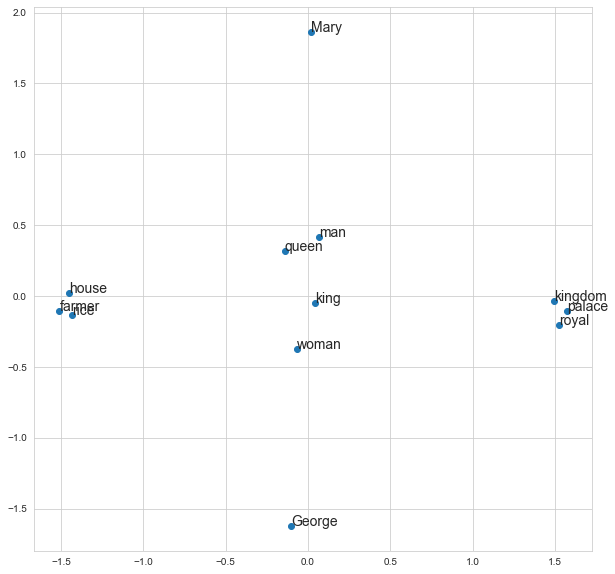

In [28]:
plt.figure(figsize=(10,10))

plt.scatter(fit[:,0],fit[:,1])

for i in range(len(word_index.keys())):
    plt.text(fit[i,0],fit[i,1],reverse_index[i], fontsize=14)

plt.show()

Before continuing with this notebook, I want to pause and show you a nice interactive web app that gives a good intuition for Word2Vec, https://ronxin.github.io/wevi/. Go to that app and play around for a bit before finishing this notebook.

## Training Word2Vec is Costly
Before moving on to the next notebook let's end with this final demonstration.

Program a loop to count the number of skip-grams that would result from the imdb data set.

In [29]:
count = 0

for i in range(len(imdb_train)):
    for gram in sequence.skipgrams(imdb_train[i], 
                                  vocabulary_size=n,
                                  window_size=window_size,
                                  negative_samples=0)[0]:
        count = count + 1

In [30]:
print("The imdb training data set would produce", count, "skip-grams")

The imdb training data set would produce 23721364 skip-grams



That's a lot of data!

To make things worse (from your laptop's perspective) in the imdb example $M =10,000$ and a standard $N$ is $300$  (based on original paper). That means we'd need to find weights for $10,000\times 300 = 3,000,000$  weights twice. (Good thing we have a lot of data).

So training your own Word2Vec embedding comes with a large start up cost compared to everything else we've done in the program.

That's why many projects don't start with the training of a custom Word2Vec embedding, but first either try some of the older techniques we've learned or use a pretrained Word2Vec embedding, the topic of Next Week's Class!